In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [2]:
question = glob.glob('../../../../ICDAR-2019-SROIE/data/box/*')

In [3]:
txt_list = []
for text in question:
    with open(text) as f:
        txt = f.read()
    txt_list.append(txt)

In [4]:
def split_only_8(string):
    comma_split_string = [elem for elem in string.split(',') if elem] 
    element_8_list = []
    leftover = []
    for idx, txt in enumerate(comma_split_string):
        if idx < 8:
            element_8_list.append(int(txt))
        else:
            leftover.append(txt)
    element_8_list.append(','.join(leftover))
    return element_8_list

In [5]:
corpus = [[split_only_8(row) for row in text.split('\n')] for text in txt_list]

In [6]:
df_list = [pd.DataFrame(c, columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4','y4','transcript']).dropna() for c in corpus]

In [7]:
def get_rownum_df(df):
    df['y_center'] = (df['y1'] + df['y4'])/2
    median_height = np.median(df['y4'] - df['y1']) // 4
    y_center = list(df.y_center)
    histdata = plt.hist(y_center, 
                    bins=range(int(min(y_center)), int(max(y_center)+median_height), int(median_height)))
    histx_ = (histdata[1][:-1] + histdata[1][1:])/2
    histx = []
    histx.append(histx_[0]-1)
    histx.extend(histx_)
    histx.append(histx_[-1]+1)
    histy = []
    histy.append(0)
    histy.extend(histdata[0])
    histy.append(0)
    histx = np.array(histx)
    histy = np.array(histy)

    localmaxima = argrelextrema(histy, np.greater)
    plt.plot(histx, histy)
    plt.plot(histx[localmaxima], histy[localmaxima], 'x')
    linedict = {num_line: histx[y] 
                for num_line, y in enumerate(localmaxima[0])} 
    rownum = []
    for idx, row in df.iterrows():
        rownum.append(np.argmin(abs(np.array(list(linedict.values())) - row.y_center)))
    df['row'] = rownum
    return df
     

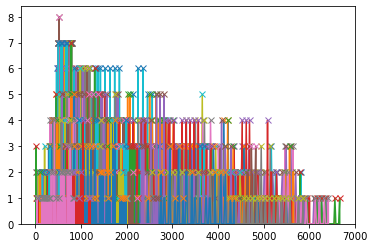

In [8]:
df_list_rownum = [get_rownum_df(df) for df in df_list]

In [9]:
df = df_list_rownum[0]

In [10]:
import re

In [11]:
amount = re.compile('\w*\s*\d+\.\d+')
re_float = re.compile('\d+\.\d+')

In [12]:
re_float.findall('RM 3.4')

['3.4']

In [13]:
amount.findall('-0.01')

['0.01']

In [202]:
def get_total_list(df):
    for rownum, row in sorted(df.groupby('row'), key=lambda e: -e[0]):
        row_text = ' '.join(row.transcript)
        if 'ROUND' in row_text.upper():
            try:
                if max(list(map(lambda e: float(re_float.findall(e)[0]), amount.findall(row_text))))<=0:
                       pass
                else:
                    return str(max(list(map(lambda e: float(re_float.findall(e)[0]), amount.findall(row_text)))))
            except ValueError:
                pass
        if 'TOTAL' in row_text.upper():
            try:
                return str(max(list(map(lambda e: float(re_float.findall(e)[0]), amount.findall(row_text)))))
            except:
                pass

In [203]:
df_total = pd.Series([get_total_list(df) for df in df_list_rownum])

In [204]:
answer = glob.glob('../../../../ICDAR-2019-SROIE/data/key/*')

In [205]:
import json

In [206]:
json_list = []
for ans in answer:
    with open(ans) as f:
        json_list.append(json.load(f))

In [207]:
json_list[1]

{'company': 'INDAH GIFT & HOME DECO',
 'date': '19/10/2018',
 'address': '27, JALAN DEDAP 13, TAMAN JOHOR JAYA, 81100 JOHOR BAHRU, JOHOR.',
 'total': '60.30'}

In [208]:
answer_df = pd.DataFrame(json_list)

In [209]:
df_total

0        9.0
1      60.31
2      33.92
3      80.91
4       30.9
       ...  
621    148.5
622     38.0
623    179.5
624      0.0
625    11.32
Length: 626, dtype: object

In [210]:
answer_df['predicted'] = df_total

In [211]:
answer_df.shape

(626, 5)

In [212]:
round(3.4,1)

3.4

In [213]:
answer_df['predicted'] = answer_df.predicted.apply(lambda e: e+'0' 
                                                   if e and len(e.split('.')[1])==1  
                                                   else e)

In [214]:
# answer_df['predicted'] = answer_df.predicted.apply(lambda e: str(round(float(e), 1))+'0' if e else e)

In [215]:
answer_ = answer_df.dropna()

In [216]:
pd.options.display.max_rows = 500 

In [217]:
answer_df['total_noncur'] = answer_df.total.apply(lambda e: re_float.findall(e)[0] if e else '')

In [218]:
answer_df[answer_df.total_noncur == answer_df.predicted].shape # 373 (위에서부터), 375(아래서부터)

(375, 6)

In [219]:
answer_df[answer_df.total_noncur != answer_df.predicted][['total_noncur','predicted']]

,total_noncur,predicted
1,60.30,60.31
2,33.90,33.92
3,80.90,80.91
5,31.00,101.00
8,112.45,106.10
9,26.60,1.51
10,14.10,0.80
11,15.00,0.85
12,15.90,50.00
14,32.70,0.00
